# Regression Pricing: Longstaff Schwarz American Monte Carlo

Pricing derivatives using regression is a popular technique for both, exotic derivatives with early exercise features, and vanilla trades. In this notebook we review the fundamental setup and demonstrate the technique in an easy example. 

In [1]:
%matplotlib widget

In [2]:
from typing import Union
import numpy as np
import scipy.stats as ss
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import cm
from IPython.display import Image
import ipywidgets as wdg

# Calculation of fMtMs via Risk Factor Evolution
Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space with filtration $\mathcal{F}_t$ and $\mathbb{Q}$ be a risk-neutral measure pertaining to some numeraire $N(t)$. Assume we have an $\mathbb{R}^d$-valued process of some risk-factors 
\begin{align*}
    dX(t) = \mu(t,X(t))dt + \sigma(t,X(t))dW(t), && X(0)=x_0
\end{align*}
and we want to perform pricing of some derivative with payoff $V(T)$ that is a function of these risk factors. By risk-neutral pricing,
\begin{align*}
    V(t) = \mathbb{E}\Big[ D(t,T) V(T) \mid \mathcal{F}_t \Big], &&
    D(t,T) := \frac{N(t)}{N(T)}.
\end{align*}
Assuming we have already performed a Monte Carlo simulation of the risk factors $X$, i.e. we have $X(t_i,\omega)$ on some time grid $0=t_0 < \ldots < t_n=T$ and some paths $\omega=1, \ldots, N$, we have three options in principle how to calculate $V(t_i,\omega)$ on any given $t_i$ in any given path $\omega$:

1. **Nested Monte Carlo:** Calculate $V(t_i,\omega) = \mathbb{E}[ D(t_i,T) V(T) \mid X_{t_i} = X(t_i,\omega)]$ by starting a new risk factor evolution with the same dynamics, but initial value $X(t_i,\omega)$ and calculate the expectation as an average. This is always possible and will converge, but is computationally very intense.
2. **Analytic Pricing:** Sometimes there is an analytic function $V(t_i,\omega)=f(t_i,X(t_i,\omega))$, which can simply be calculated. This is a very accurate and often very fast way of calculating fMtMs, but not every derivative price has an analytic function for the given risk factor evolution $X$. The downside of this apporach is that all such analytic formulae need to be derived, implemented and validated for each model and each product.
3. **Regression Pricing:** We approximate the former two methods by using regression. We define $Y_i := V(T,\omega_i)D(t_i,T)$, i.e. the dependent variable is the discounted payoff and $X_i = X(t_i)$ are the risk factors. We then regress $X_i$ against $Y_i$ and obtain some regression polynomial $f_{\beta}(x;t_i)$. We then obtain the regression fMtM $f_\beta(X_i,t_i)$. We repeat this process backwards until we reach $t=0$.

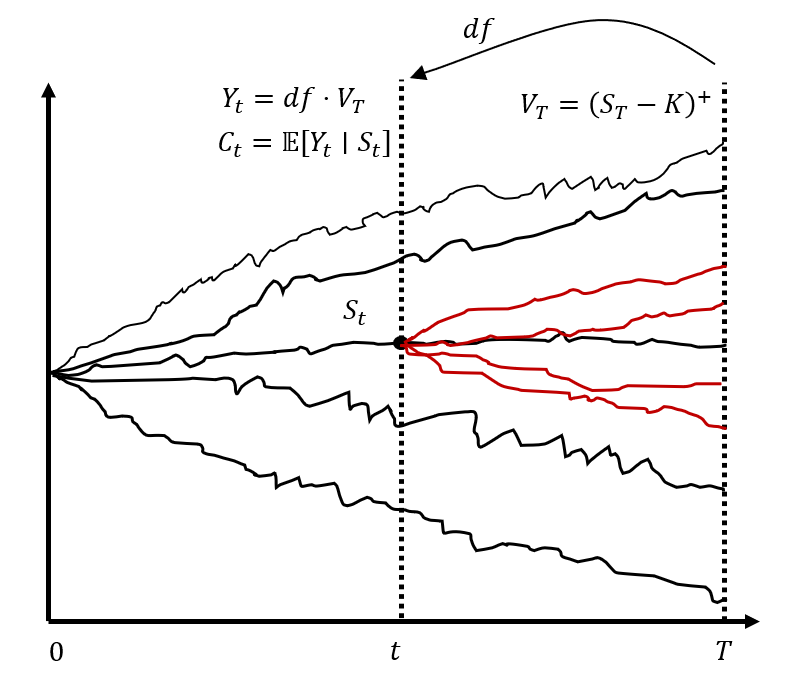

In [4]:
Image(filename='american_option_pricing.png')

# Principle of Regresion Pricing
By risk-neutral pricing, the price of a derivative is a conditional expectation. There is a deep relationship between conditional expectations and least squares linear regression that is provided by the following theorem.

**Theorem (orthogonal Projection)**: Let $Y \in L^2(\mathcal{F})$ be a real random variable and $\mathcal{G} \subset \mathcal{F}$ be a $\sigma$-subalgebra. Then for any $\mathcal{G}$-measurable random variable $Z$:
\begin{align*}
    \mathbb{E}[(Y - Z)^2] 
    = \mathbb{E}[(Y - \mathbb{E}[Y \mid \mathcal{G}])^2] + \mathbb{E}[(\mathbb{E}[Y \mid \mathcal{G}] - Z)^2]
    \geq \mathbb{E}[(Y - \mathbb{E}[Y \mid \mathcal{G}])^2]
\end{align*}
with equality if and only if $Z=\mathbb{E}[Y \mid \mathcal{G}]$.

**Corollary**: In particular if $X$ is a real random variable, $\mathcal{G} = \sigma(X)$ and $g:\mathbb{R} \to \mathbb{R}$ is measurable, then
\begin{align*}
    \| Y - g(X) \|_{L^2}^2 
    = \|Y - \mathbb{E}[Y \mid X]\|_{L^2}^2 + \|\mathbb{E}[Y \mid X] - f(X)\|_{L^2}^2.
    \geq \|Y - \mathbb{E}[Y \mid X]\|_{L^2}^2
\end{align*}
with equality if and only if $g(x) = \mathbb{E}[Y \mid X=x]$.

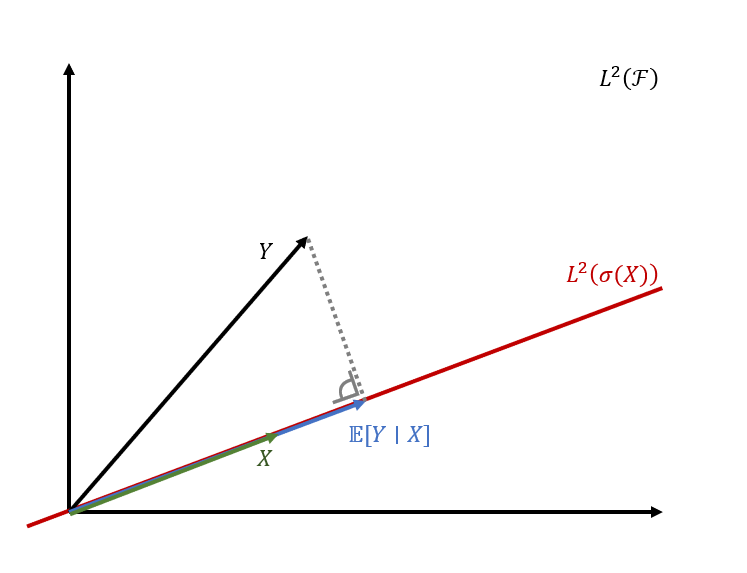

In [5]:
Image(filename='conditional_expectation_orthogonal_projection.png')

Geometrically this means that the conditional expectation $f(X)=\mathbb{E}[Y \mid X]$ of $Y$ given $X$ is the $L^2$-orthogonal projection of $Y$ into the subspace spanned by the $\sigma(X)$-measureable functions. One key property of orthogonal projections is that they minimize the least squares. Thus, if $(Y,X)$ is a pair of random variables and $f(x) = \mathbb{E}[Y \mid X=x]$ and $\hat f$ is some estimate of $f$, we will always have
\begin{align*}
    \mathbb{E}[(Y-\hat f(X))^2] \geq \mathbb{E}[(Y-f(X))^2].
\end{align*}
We can use this principle to find (a best approximation) to $f$: If $(Y_i, X_i)$, $i=1, \ldots, N$, are iid, then $(Y_i - f(X_i))^2$ and $(Y_i - \hat f(X_i))^2$ are iid as well. Hence by law of large numbers
\begin{align*}
    \lim_{N \to \infty}{\frac{1}{N}\sum_{i=1}^{N}{(Y_i - \hat f(X_i))^2}} 
    = \mathbb{E}[(Y-\hat f(X))^2] 
    \geq \mathbb{E}[(Y-f(X))^2]
     =\lim_{N \to \infty}{\frac{1}{N}\sum_{i=1}^{N}{(Y_i - \hat f(X_i))^2}}
\end{align*}
This means that in theory, if we had infinite data and if we would look for the conditional expectation in a function space $\mathcal{H}$ that contains the true function $f$, least squares linear regression would yield $\hat f = f$. However, in practice we only have a finite number $N$ of data points and the hypothesis space $\mathcal{H}$ of functions might not contain $f$. A typical choice is to lookt for the function in a space  $\mathcal{H}$ of all functions $f_\beta$ of the form
\begin{align*}
    f_\beta(x) = \beta^\top \Phi(x),
\end{align*}
where $\Phi:\mathbb{R}^d \to \mathbb{R}^k$ is some *feature extraction* map and $\beta \in \mathbb{R}^k$ are some coefficients. The condition
\begin{align*}
    \beta^* := \operatorname{argmin}_{\beta}{\mathbb{E}[(Y-f_{\beta}(X))^2]}
\end{align*}
ensures we find the best approximation to $f$ in the space $\mathcal{H}$ by minimizing the least squares. This is the motivation to minmize the least squares cost functional
\begin{align*}
    J(\beta) := \frac{1}{N} \sum_{i=1}^N{(Y_i - f_{\beta}(X_i))^2}
\end{align*}
in linear regression to approxmate the conditional expectation and hence the price.


There are two major applications of this principle:
* **Pricing American Options**: The original idea by Longstaff/Schwarz was to use this principle not to obtain the value of a general derivative, but the continuation value of a derivative with early exercise features such as American Options. This continuation value can then be used to price the derivative, which is difficult by other means.
* **Pricing Vanilla Derivatives:** Regression is a way to transform cashflows into polynomials and this is a useful approximation even for vanilla derivatives as well. It speeds up computations of complex quantities like intra-day xVA and ensures consistency across the valuations between American and Vanilla derivatives.

# Example
We illustrate this technique using a simple Black-Scholes model for option pricing.

## Black Scholes Pricing

In [6]:
def simulate_gbm(x0: float, mu: float, sigma: float, time_grid: np.ndarray, dw: np.ndarray) -> np.ndarray:
    num_times = time_grid.shape[0]
    num_paths = dw.shape[0]
    drift = np.zeros((num_paths, num_times))
    diff = np.zeros((num_paths, num_times))
    delta = (time_grid[1:] - time_grid[:-1])[np.newaxis, :]
    drift[:, 1:] = (mu - sigma ** 2 / 2) * delta
    diff[:, 1:] = np.sqrt(delta) * sigma * dw
    paths = np.cumprod(np.exp(drift + diff), axis=1)
    return paths * x0

def option_price(sigma: float, r: float, maturity: float, strike: float, st: Union[float, np.ndarray], t: float = 0, put_call='call') -> Union[float, np.ndarray]:
    tau = maturity - t
    if tau < 0:
        return 0.
    dp = dp_aux(sigma, r, strike, st, tau)
    dm = dp - sigma * np.sqrt(tau)
    fwd = np.exp(r * tau) * st
    df = np.exp(-r * tau)
    cdf = ss.norm(loc=0, scale=1).cdf
    if put_call == 'call':
        return df * (fwd * cdf(dp) - strike * cdf(dm))
    elif put_call == 'put':
        return df * (strike * cdf(-dm) - fwd * cdf(-dp))

def forward_price(r: float, maturity: float, strike: float, st:  Union[float, np.ndarray],
                  t: float = 0) -> Union[float, np.ndarray]:
    tau = maturity - t
    if tau < 0:
        return 0.
    df = np.exp(- r * tau)
    return st - df * strike

def dp_aux(sigma: float, r: float, strike: float, st: float, tau: float) -> Union[float, np.ndarray]:
    dp = np.log(st / strike) + (r+ sigma ** 2 / 2) * tau
    return dp / (sigma * np.sqrt(tau))

In [7]:
# set parameters
s0 = 100
r = 0.03
sigma = 0.10
t1 = 1
t2 = 2
maturity = 3
time_grid = np.array([0, t1, t2, maturity])
N = 1000
strike = 100
n = time_grid.shape[0] - 1

In [8]:
# simulate underlying
np.random.seed(2)
dw = np.random.normal(0, 1, (N, n))
stock =  simulate_gbm(s0, r, sigma, time_grid, dw)
idx = 2
x = stock[:,idx]
y = np.exp(-r * (maturity-time_grid[idx])) * np.maximum(stock[:,-1]-strike, 0)
X = x[:,np.newaxis]

# calculate correct result for verification plots
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
f_sorted = option_price(sigma, r, maturity, strike, x_sorted, time_grid[idx], put_call='call')
y_sorted = y[sort_idx]

In [9]:
# perform regressions
degrees = [0,1,2,3,4,5]
regs = []
y_pred = []

for d in degrees:
    reg = LinearRegression()
    if d > 0:
        model = make_pipeline(PolynomialFeatures(degree=d, include_bias=False), LinearRegression())
    else:
        model = make_pipeline(PolynomialFeatures(degree=0, include_bias=True), LinearRegression())
    model.fit(X, y)
    y_pred.append(model.predict(X))
    regs.append(model)

# calculate residuals
res = np.array([y-yp for yp in y_pred])
res_true = y - option_price(sigma, r, maturity, strike, x, time_grid[idx], put_call='call')

In [10]:
# plot results
colors = plt.cm.tab10.colors
fig_scatter, ax_scatter = plt.subplots()
fig_scatter.suptitle('True vs Regression Polynomial from Data')

@wdg.interact(d=wdg.IntSlider(min=degrees[0], max=degrees[-1], value=degrees[1]))
def plot_regression(d):
    ax_scatter.clear()
    ax_scatter.scatter(x_sorted, y_sorted, s=1, alpha=0.2, label='data')
    ax_scatter.plot(x_sorted , f_sorted, color='k', label='f true')
    ax_scatter.plot(x_sorted , y_pred[d][sort_idx], label=f'f reg deg={d}', c=colors[d+1])
    ax_scatter.set_xlabel('stock')
    ax_scatter.set_ylabel('option')
    ax_scatter.set_xlim([60, 180])
    ax_scatter.set_ylim([-20, 100])
    plt.legend()
    plt.show()
    plt.savefig('lsm_regpoly_vs_true.pdf')

interactive(children=(IntSlider(value=1, description='d', max=5), Output()), _dom_classes=('widget-interact',)…

In [11]:
fig_scatter_res_stock, ax_scatter_res_stock = plt.subplots()
fig_scatter_res_stock.suptitle('Stock vs Residuals')

@wdg.interact(d=wdg.IntSlider(min=degrees[0], max=degrees[-1], value=degrees[1]))
def plot_regression_residuals_stock(d):
    ax_scatter_res_stock.clear()
    ax_scatter_res_stock.scatter(x, res_true, s=2, label='true')
    ax_scatter_res_stock.scatter(x, res[d], s=2, label=f'deg={d}')    
    ax_scatter_res_stock.set_xlabel('stock')
    ax_scatter_res_stock.set_ylabel('residual')
    ax_scatter_res_stock.set_xlim([60, 180])
    ax_scatter_res_stock.set_ylim([-50, 100])
    plt.legend(loc='upper right')
    plt.show()
plt.savefig('lsm_stock_vs_residuals.pdf')

interactive(children=(IntSlider(value=1, description='d', max=5), Output()), _dom_classes=('widget-interact',)…

In [12]:
#from matplotlib.animation import FuncAnimation, PillowWriter
#anim = FuncAnimation(fig_scatter_res_stock, plot_regression_residuals_stock, frames=degrees, blit=True)
#anim.save('lsm_stock_vs_residuals.gif', writer=PillowWriter(fps=1/2))

In [13]:
fig_scatter_res, ax_scatter_res = plt.subplots()
fig_scatter_res.suptitle('Residuals True vs Regression')

@wdg.interact(d=wdg.IntSlider(min=degrees[0], max=degrees[-1], value=degrees[1]))
def plot_regression_residuals(d):
    ax_scatter_res.clear()
    ax_scatter_res.scatter(res_true, res[d], s=2, label=f'deg={d}')    
    ax_scatter_res.plot([-50, 100],[-50, 100],c='k',linestyle='--')
    ax_scatter_res.set_xlabel('true residual')
    ax_scatter_res.set_ylabel('regression residual')
    ax_scatter_res.set_xlim([-50, 100])
    ax_scatter_res.set_ylim([-50, 100])
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=1, description='d', max=5), Output()), _dom_classes=('widget-interact',)…

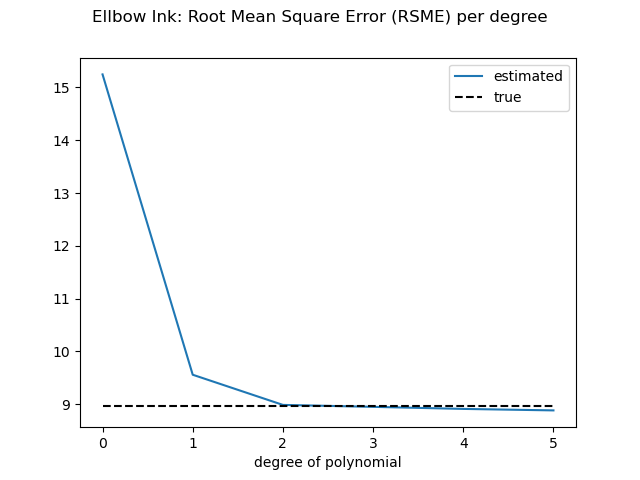

In [14]:
fig_elb, ax_elb = plt.subplots()
fig_elb.suptitle('Ellbow Ink: Root Mean Square Error (RSME) per degree')
ax_elb.plot(degrees, np.sqrt((res**2).mean(axis=1)), label='estimated')
ax_elb.plot(degrees, np.sqrt(np.ones_like(degrees) * (res_true**2).mean()), label='true', linestyle='--', color='k')
ax_elb.set_xlabel('degree of polynomial')
plt.legend()
plt.show()
plt.savefig('lsm_ellbow_kink.pdf')

In [15]:
bins_res = np.linspace(-50,50, 30)
bwidth = 2
hist_true = np.histogram(res_true, bins=bins_res, density=False)[0]

fig_res, ax_res = plt.subplots()
fig_res.suptitle('PDF of Residuals')

@wdg.interact(d=wdg.IntSlider(min=degrees[0], max=degrees[-1], value=degrees[1]))
def plot_residual(d):
    ax_res.clear()
    hist_deg = np.histogram(res[d], bins=bins_res, density=False)[0]
    ax_res.bar(bins_res[:-1]-bwidth/2, hist_true, label=f'true', width=bwidth/2, alpha=1)
    ax_res.bar(bins_res[:-1]+bwidth/2, hist_deg, label=f'deg={d}', width=bwidth/2, alpha=1)
    ax_res.set_xlabel('residual')
    ax_res.set_ylabel('frequency')
    ax_res.set_xlim([bins_res[0],bins_res[-1]])
    ax_res.set_ylim([0,400])
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=1, description='d', max=5), Output()), _dom_classes=('widget-interact',)…

In [16]:
fig_res_ecdf, ax_res_ecdf = plt.subplots()
fig_res_ecdf.suptitle('ECDF of Residuals')

@wdg.interact(d=wdg.IntSlider(min=degrees[0], max=degrees[-1], value=degrees[1]))
def plot_residual_ecdf(d):
    ax_res_ecdf.clear()
    ax_res_ecdf.plot(bins_res, ECDF(res_true)(bins_res), label=f'true', color='k')
    ax_res_ecdf.plot(bins_res, ECDF(res[d])(bins_res), label=f'deg={d}')   
    ax_res_ecdf.set_xlabel('residual')
    ax_res_ecdf.set_ylabel('frequency')
    ax_res_ecdf.set_xlim([bins_res[0],bins_res[-1]])
    ax_res_ecdf.set_ylim([0,1.1])
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=1, description='d', max=5), Output()), _dom_classes=('widget-interact',)…

# References
* Longstaff, Schwarz. *Valuing American Options by Simulation* [PDF](https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf).